In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

import eli5
from IPython.display import display
from eli5.permutation_importance import get_score_importances
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import itertools
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
COMP_PATH = "icr-identify-age-related-conditions"

train_df = pd.read_csv(f'{COMP_PATH}//train.csv')
test_df = pd.read_csv(f'{COMP_PATH}/test.csv')
greeks = pd.read_csv(f"{COMP_PATH}/greeks.csv")
sample_submission = pd.read_csv(f"{COMP_PATH}/sample_submission.csv")

train_df['EJ'] = train_df['EJ'].replace({'A': 0, 'B': 1})
test_df['EJ'] = test_df['EJ'].replace({'A': 0, 'B': 1})

train_df.columns = train_df.columns.str.replace(' ', '')
test_df.columns = test_df.columns.str.replace(' ', '')

# train_df.drop('Id',axis=1, inplace=True)
# train_df.fillna(train_df.median(), inplace=True)

# Standard Scaler

In [3]:
# scaler = StandardScaler()
# new_num_cols = train_df.select_dtypes(include=['float64']).columns

# train_df[new_num_cols] = scaler.fit_transform(train_df[new_num_cols])
# test_df[new_num_cols] = scaler.transform(test_df[new_num_cols])

# Brute Force Feature Generation

Combine features in all possible ways.

In [4]:
features = train_df.drop(['Class', 'Id'], axis=1).columns

selected = ['AB+DU', 'DU-EH', 'EL-FI', 'BQ-CH', 'DU*EJ', 'CR*EH', 'AY*CC',
            'CH/FR', 'BQ/FD', 'BQ*EJ_05', 'CR_05*DU', 'DL*EL_05', 'CD*GL_05',
            'FC*FI_05', 'AB_05*FD', 'EJ_05*FR', 'FI_05*FL', 'EE_log*FL',
            'AB*DL_log', 'CD*GL_log', 'GL_2', 'BQ*DU_2', 'DI_2*EL']

best_orig = ['DU', 'BQ', 'AB', 'CR', 'CH', 'GL', 'DA', 'FI', 'DY', 'EL', 'DN', 'AM',
             'DL', 'CC', 'EU', 'EB', 'AF', 'CD', 'EP', 'CB', 'FR', 'CS', 'GE', 'AX',
             'DE', 'DI', 'FS', 'GI', 'CL', 'EJ']

def gen_features(features, df):
    generated_features = pd.DataFrame()

    for fe_a, fe_b in tqdm(itertools.combinations(features, 2)):
        generated_features[f'{fe_a}+{fe_b}']   = df[fe_a] + df[fe_b]
        generated_features[f'{fe_a}-{fe_b}']   = df[fe_a] - df[fe_b] 
        generated_features[f'{fe_a}*{fe_b}']   = df[fe_a] * df[fe_b]
        generated_features[f'{fe_a}/{fe_b}']   = df[fe_a] / df[fe_b]

        generated_features[f'{fe_a}_2']        = df[fe_a].pow(2)
        generated_features[f'{fe_b}_2']        = df[fe_b].pow(2)
        generated_features[f'{fe_a}*{fe_b}_2'] = df[fe_a] * df[fe_b].pow(2)
        generated_features[f'{fe_a}_2*{fe_b}'] = df[fe_a].pow(2) * df[fe_b]

        generated_features[f'{fe_a}_05'] = df[fe_a].pow(0.5)
        generated_features[f'{fe_b}_05'] = df[fe_b].pow(0.5)
        generated_features[f'{fe_a}*{fe_b}_05'] = df[fe_a] * df[fe_b].pow(0.5)
        generated_features[f'{fe_a}_05*{fe_b}'] = df[fe_a].pow(0.5) * df[fe_b]

        generated_features[f'{fe_a}_log'] = np.log(df[fe_a])
        generated_features[f'{fe_b}_log'] = np.log(df[fe_b])
        generated_features[f'{fe_a}*{fe_b}_log'] = df[fe_a] * np.log(df[fe_b])
        generated_features[f'{fe_a}_log*{fe_b}'] = np.log(df[fe_a]) * df[fe_b]
        
    print(generated_features.head())
    generated_features = generated_features[selected]
    generated_features = pd.concat([generated_features, df[best_orig]], axis=1)
    
    # prevent inf
    for g in generated_features.columns:
        generated_features[g] = np.minimum(np.maximum(generated_features[g], -1e9), 1e9)
    
    return generated_features

generated_features_train = gen_features(features, train_df)
generated_features_test = gen_features(features, test_df)


         AB+AF        AB-AF        AB*AF     AB/AF      AB_2          AF_2  \
0  3109.242667 -3108.823913   650.960063  0.000067  0.043839  9.666088e+06   
1   978.909442  -978.618878   142.196815  0.000148  0.021107  9.579793e+05   
2  2635.576570 -2634.636510  1238.579127  0.000178  0.220928  6.943786e+06   
3  3819.903877 -3819.399663   962.960949  0.000066  0.063558  1.458974e+07   
4  3733.428737 -3732.668143  1419.667123  0.000102  0.144626  1.393565e+07   

        AB*AF_2     AB_2*AF     AB_05      AF_05  ...      GI+GL      GI-GL  \
0  2.023857e+06  136.296065  0.457577  55.758706  ...  69.955287  69.714601   
1  1.391771e+05   20.658638  0.381159  31.285207  ...  54.109996  10.153996   
2  3.263788e+06  582.169347  0.685587  51.333289  ...  35.389617  34.995735   
3  3.678175e+06  242.769196  0.502103  61.803331  ...  90.649077  90.337419   
4  5.299686e+06  539.895148  0.616682  61.098678  ...  36.359242  36.166014   

        GI*GL       GI/GL       GI*GL_2       GI_2*GL  


   AB+AF  AB-AF  AB*AF  AB/AF  AB_2  AF_2  AB*AF_2  AB_2*AF  AB_05  AF_05  \
0    0.0    0.0    0.0    NaN   0.0   0.0      0.0      0.0    0.0    0.0   
1    0.0    0.0    0.0    NaN   0.0   0.0      0.0      0.0    0.0    0.0   
2    0.0    0.0    0.0    NaN   0.0   0.0      0.0      0.0    0.0    0.0   
3    0.0    0.0    0.0    NaN   0.0   0.0      0.0      0.0    0.0    0.0   
4    0.0    0.0    0.0    NaN   0.0   0.0      0.0      0.0    0.0    0.0   

   ...  GI+GL  GI-GL  GI*GL  GI/GL  GI*GL_2  GI_2*GL  GI*GL_05  GI_05*GL  \
0  ...    0.0    0.0    0.0    NaN      0.0      0.0       0.0       0.0   
1  ...    0.0    0.0    0.0    NaN      0.0      0.0       0.0       0.0   
2  ...    0.0    0.0    0.0    NaN      0.0      0.0       0.0       0.0   
3  ...    0.0    0.0    0.0    NaN      0.0      0.0       0.0       0.0   
4  ...    0.0    0.0    0.0    NaN      0.0      0.0       0.0       0.0   

   GI*GL_log  GI_log*GL  
0        NaN        NaN  
1        NaN        NaN  
2

# LGBM parameters

In [5]:
params = {
        'boosting_type':'goss',
        'learning_rate': 0.06733232950390658, 
        'n_estimators': 50000, 
        'early_stopping_round' : 100, 
        'random_state': 42,
        'subsample' : 0.6970532011679706,
        'colsample_bytree': 0.6055755840633003,
        'class_weight': 'balanced',
        'metric': 'none', 
        'is_unbalance': True, 
        'max_depth': 8}

# Train / validate / count permutation importance

In [6]:
n_splits = 2
n_rounds = 50

final_valid_predictions = []
final_test_predictions = []

valid_weights = []
test_weights = []

def balanced_log_loss(y_true, y_pred):

    # Nc is the number of observations
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    # In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with max(min(𝑝,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # balanced logarithmic loss
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1 - y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

def bll_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

def get_metric(n_rounds, n_splits, permut):
    # statistics dataframes
    perm_df = pd.DataFrame()
    oof_stats = list()

    #Split Data
    for i in tqdm(range(n_rounds)):
#         x_train, y_train = train_df[best_features], train_df.Class
        x_train, y_train = generated_features_train, train_df.Class

        #Storage for oof scroe of current resampled dataset
        oof_score = pd.DataFrame(index=x_train.index, columns=['preds'])

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 6062023 + i)
        for fold, (train_index, val_index) in enumerate(skf.split(x_train, greeks['Alpha'])):
            X_train, Y_train, X_val, Y_val = x_train.iloc[train_index], y_train[train_index], x_train.iloc[val_index], y_train[val_index]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], 
                    eval_metric=bll_metric, verbose=-1)

            preds = clf.predict_proba(X_val)[:,1]
            
            # collect data for the test predicton
            preds_test = clf.predict_proba(generated_features_test)
#             preds_test = clf.predict_proba(test_df[best_features])
            
            final_test_predictions.append(preds_test)

            b_logloss = balanced_log_loss(Y_val, preds)
            test_weights.append(1/b_logloss)
            
            # OOF score for statistics
            oof_score.loc[val_index, 'preds'] = preds
            
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, Y_val)


                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                   index=X_val.columns).sort_index()

                if perm_df.shape[0] == 0:
                    perm_df = perm_importance_df.copy()
                else:
                    perm_df += perm_importance_df

        #Compute & store oof score of current dataset
        logloss_folds = balanced_log_loss(y_train, oof_score.preds.astype('float'))
        
        # collect data for the validation predicton
        valid_weights.append(1/logloss_folds)
        final_valid_predictions.append(oof_score.preds.astype('float'))
        
        oof_stats.append(logloss_folds)

    # collect all permutation importances into the dataset and then avearge them by number of rounds * folds
    if permut:
        perm_df /= n_splits * n_rounds

        perm_df = perm_df.sort_values('importance', ascending=False)
        perm_df.to_csv('perm_df_log.csv')
        
    return oof_stats, perm_df

oof_stats, perm_df = get_metric(n_rounds=n_rounds, n_splits=n_splits, permut=False)

In [7]:
# perm_df = pd.read_csv('perm_df_log.csv', index_col='Unnamed: 0')
# best_features = perm_df[perm_df.importance > 0.001].index

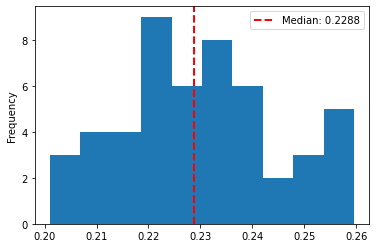

In [8]:
# My features + his features + best original features
pd.Series(oof_stats).plot(kind='hist')
median_value = pd.Series(oof_stats).median()
plt.axvline(median_value, color='r', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')
plt.legend()
plt.show()

# Predict valid

In [9]:
valid_preds = np.zeros((train_df.shape[0],1))

for i in range(len(final_valid_predictions)):
    valid_preds[:,0] += valid_weights[i] * final_valid_predictions[i]

valid_preds /= sum(valid_weights)

balanced_log_loss(train_df['Class'], valid_preds[:,0])

0.19845508556912062

# Predict test

In [10]:
test_preds = np.zeros((test_df.shape[0],2))

for i in range(len(final_test_predictions)):
    test_preds[:, 0] += test_weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += test_weights[i] * final_test_predictions[i][:, 1]

test_preds /= sum(test_weights)

sample_submission[['class_0', 'class_1']] = test_preds
sample_submission.to_csv(r"submission.csv", index=False)

You have a lot of resulting features. I have already identified a few important once. 

# Further ideas:

ID repeat?
Encode Epsilon as ordinal
Add A